# MovieLens Project Analysis Report

In [1]:
import pandas as pd
import sqlalchemy as db
import numpy as np
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import Column, Integer, Float, String, ForeignKey


#### Lets import the movies and ratings datasets and dispaly them

In [4]:
df_movies = pd.read_csv("ml-25m/movies.csv")
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_ratings = pd.read_csv("ml-25m/ratings.csv")
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [7]:
print('Total no of users are: {}'.format(len(df_ratings['userId'].value_counts())))
print('Total no of movies are: {}'.format(len(df_movies['movieId'].value_counts())))

Total no of users are: 162541
Total no of movies are: 62423


Text(0.5, 1.0, 'Rating counts')

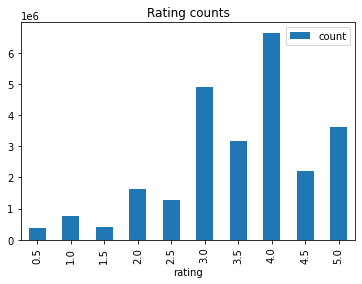

In [38]:
pd.DataFrame(df_ratings.groupby(['rating']).size(), columns=['count'])[["count"]].plot(kind='bar').set_title("Rating counts")

array([<AxesSubplot:ylabel='count'>], dtype=object)

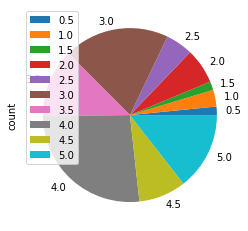

In [73]:
pd.DataFrame(df_ratings.groupby(['rating']).size(), columns=['count']).plot(kind='pie', subplots=True)

So largest ratings are given as 4 and then 3 , 5. so we can mark the positive rating with condition of greater than, equal to 4

In [51]:
# lets suppose that there are negligible ratings given more then 1 to same movies by same users....
zero_ratings = len(df_ratings['userId'].value_counts())*len(df_movies['movieId'].value_counts()) - len(df_ratings)
zero_ratings
# 

10121296748

So there are 10121296748 ratings which are by default zeros because they are not availabe

<AxesSubplot:xlabel='movieId'>

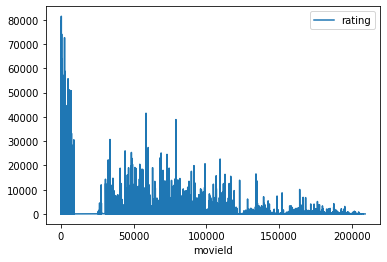

In [69]:
count_rated_movies_dict = df_ratings[["movieId","rating"]].groupby(["movieId"]).count()
count_rated_movies_dict.plot.line()

Only some of movies are highly rated and its quit natural as only small portion of material goes on trending in the world and they are also rated highly and everyone like it.

## Collaborative Recommender system
In code I have Implemented the Collaborative Recommender system. As teh name suggests its based on the collaboration of item and then on the basis of it a recommentation is performed. In our case we find the collaboration between the users using KNN model and then on the basis of similar users we recommend the movies which is not already seen by the given user.

### common Isses:
* This method also produce some common problems e.g. if we are working on large datasets then it produces very large feature and sparce matrix. 
* Apart from it we also face the cold start problem. i.e if we have a new user with no previously wached movies.

## Recommendations for New users

In [83]:
mean_rated_movies_dict = df_ratings[["movieId", "rating"]].groupby(["movieId"]).mean()
mean_rated_movies_dict.rename(columns={'rating': 'average'}, inplace=True)
# mean_rated_movies_dict.head()
count_rated_movies_dict = df_ratings[["movieId", "rating"]].groupby(["movieId"]).count()
count_rated_movies_dict.rename(columns={'rating': 'count'}, inplace=True)
average_count_ratings = pd.merge(mean_rated_movies_dict.loc[mean_rated_movies_dict["average"]>=4], count_rated_movies_dict.loc[count_rated_movies_dict["count"]>500], on='movieId')
# print(average_count_ratings.head(5))
prepared_df=pd.merge(df_movies, average_count_ratings, on='movieId')[["title","average", "count"]]

### We can get the high average rating movies and can recommend to the new users :

In [86]:
prepared_df[["title","average"]].sort_values(by='average', ascending=False).head()


,title,average
291,Planet Earth II (2016),4.483096
281,Planet Earth (2006),4.464797
14,"Shawshank Redemption, The (1994)",4.413576
290,Band of Brothers (2001),4.398599
29,"Godfather, The (1972)",4.324336


### Most popular movies recommended to the new users :

In [87]:
prepared_df[["title","count"]].sort_values(by='count', ascending=False).head()

,title,count
16,Forrest Gump (1994),81491
14,"Shawshank Redemption, The (1994)",81482
12,Pulp Fiction (1994),79672
19,"Silence of the Lambs, The (1991)",74127
148,"Matrix, The (1999)",72674


### Most popular and highly rated movie recommended to the new users :

In [88]:
prepared_df.sort_values(by=['count','average'], ascending=False).head()

,title,average,count
16,Forrest Gump (1994),4.048011,81491
14,"Shawshank Redemption, The (1994)",4.413576,81482
12,Pulp Fiction (1994),4.188912,79672
19,"Silence of the Lambs, The (1991)",4.151342,74127
148,"Matrix, The (1999)",4.154099,72674


In [2]:
DATABASE_USER = "root"
DATABASE_PASSWD = "786786"
DATABASE_HOST = "localhost"
DATABASE_NAME = "db1"
database_connection_str = "mysql+pymysql://%s:%s@%s/%s" %(DATABASE_USER,DATABASE_PASSWD,DATABASE_HOST,DATABASE_NAME)
def get_connection():
    return db.create_engine(database_connection_str, pool_timeout=20, pool_recycle=299)
Session = sessionmaker(bind=get_connection())
metadata = db.MetaData()
Base=declarative_base()
session = Session()

In [3]:
class Movies(Base):
    __tablename__ = 'movies'
    movieId = Column(Integer, primary_key=True)
    title = Column(String)
    genres = Column(String)
    
class Ratings(Base):
    __tablename__ = 'ratings'
    ratingId = Column(Integer, primary_key=True)
    userId = Column(Integer)
    movieId = Column(Integer, ForeignKey('Movies.movieId'))
    rating = Column(Float)
    timestamp = Column(Integer)
    
class RatingsAverageCount(Base):
    __tablename__ = 'ratings_average_count'
    movieId = Column(Integer, ForeignKey('Movies.movieId'), primary_key=True)
    average = Column(Float)
    count = Column(Integer)
    
class Tags(Base):
    __tablename__ = 'tags'
    tagId = Column(Integer, primary_key=True)
    userId = Column(Integer, ForeignKey('Ratings.userId'))
    movieID = Column(Integer, ForeignKey('Movies.movieId'))
    tag = Column(String)
    timestamp = Column(Integer)